# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline


In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

### 1. Portfolio description 

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.shape

(10, 6)

In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


### Uniqueness 

In [6]:
portfolio.difficulty.unique()

array([10,  0,  5, 20,  7])

In [7]:
portfolio.duration.unique()

array([ 7,  5,  4, 10,  3])

In [8]:
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [9]:
portfolio.reward.unique()

array([10,  0,  5,  3,  2])

### Null values 

In [10]:
# Calculate null values in portfolio dataframe
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

### Clean Portfolio Data:
* portfolio: rename id col name to offer_id.
* portfolio: one-hot encode channels
* portfolio: one-hot encode offer_type column
* convert time feature from days to hours

In [11]:
#Rename id col name to offer_id
portfolio.rename(columns={'id':'offer_id'},inplace=True)

# Make separate columns for values in feature channels list
portfolio['web'] = portfolio['channels'].apply(lambda x: int(1) if 'web' in x else int(0))
portfolio['email'] = portfolio['channels'].apply(lambda x: int(1) if 'email' in x else int(0))
portfolio['mobile'] = portfolio['channels'].apply(lambda x: int(1) if 'mobile' in x else int(0))
portfolio['social'] = portfolio['channels'].apply(lambda x: int(1) if 'social' in x else int(0))

# Make separate columns for values in feature offer type list
portfolio['bogo'] = portfolio['offer_type'].apply(lambda x: int(1) if 'bogo' in x else int(0))
portfolio['informational'] = portfolio['offer_type'].apply(lambda x: int(1) if 'informational' in x else int(0))
portfolio['discount'] = portfolio['offer_type'].apply(lambda x: int(1) if 'discount' in x else int(0))

# Drop channels and offertype column
portfolio.drop(columns=['channels','offer_type'],axis=1, inplace=True)

# Re-order columns of portfolio dataframe
col_order = ['offer_id', 'difficulty', 'duration', 'reward', 'bogo', 'discount', 'informational', 'web', 'email',\
             'mobile', 'social']

#Convert time feature from days to hours
portfolio['duration'] = portfolio['duration']*24
portfolio

,difficulty,duration,offer_id,reward,web,email,mobile,social,bogo,informational,discount
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,1,0
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,0,1
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,0,1
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,0,1
7,0,72,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,1,0
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,0,1


## Profile description 

In [12]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [13]:
profile.shape

(17000, 5)

In [14]:
# Calculate null values in profile dataframe
profile.isnull().sum(0)

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

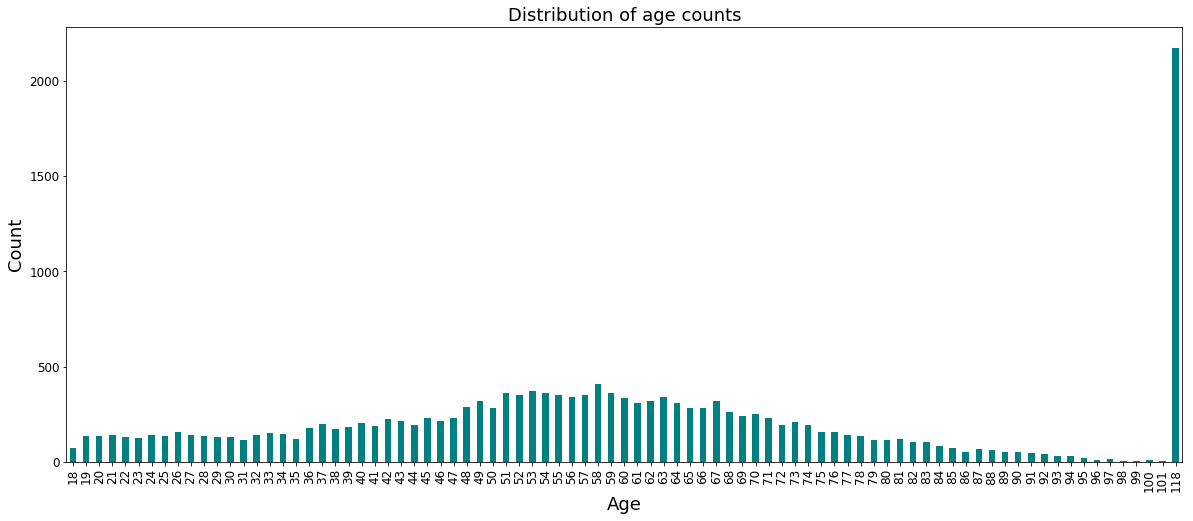

In [15]:
# Plot distribution of ages in profile dataframe 
profile['age'].value_counts().sort_index(ascending=True).plot.bar(figsize=(20,8), fontsize=12,color='teal');
plt.xlabel('Age', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.title('Distribution of age counts', fontsize=18)
plt.show()

Customers with age 118 seems to be an outlier, where the number of customers with age 118 is 2175, which is unrealistic and will be dropped fromt the dataframe.  

In [16]:
#Gender counts 
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

### Clean Profile Data
* rename id col name to customer_id.
* encode age value 118 to NaN.
* create readable date format in became_member_on column.
* drop rows with no gender, income, age data
* convert gender values to numeric 0s and 1s
* add start year and start month columns (for further analysis)

In [17]:
#rename id col name to customer_id.
profile.rename(columns={'id':'customer_id'},inplace=True)

#encode age value 118 to NaN
profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)

#create readable date format for became_member_on column.
profile.became_member_on = profile['became_member_on'].astype(str).astype('datetime64[ns]', format = "%Y%m%d")

#drop rows with no gender, income, age data
profile = profile.drop(profile[profile['gender'].isnull()].index)

#convert gender values to numeric 0s and 1s
profile['gender'] = profile['gender'].apply(lambda x: 1 if x == 'M' else 0)

#add start_year column
profile['start_year'] = profile.became_member_on.dt.year
profile["start_month"] = profile.became_member_on.dt.month

profile.head()

,age,became_member_on,gender,customer_id,income,start_year,start_month
1,55.0,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7
3,75.0,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5
5,68.0,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,4
8,65.0,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2
12,58.0,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11


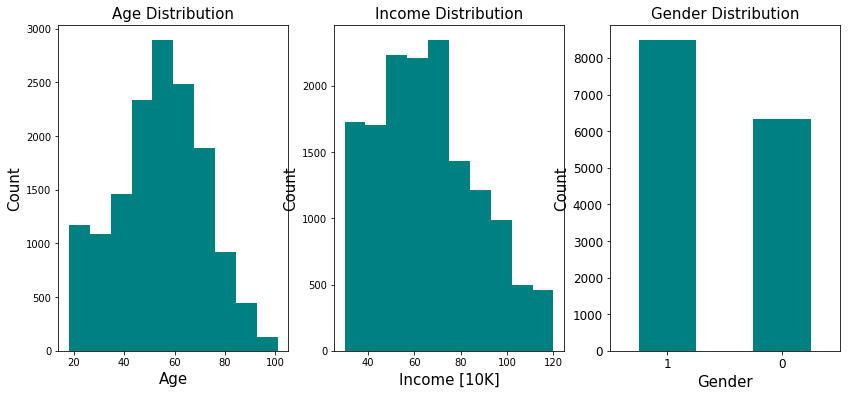

In [18]:
fig, ax = plt.subplots(figsize=(14, 6), nrows=1, ncols=3)

# plot a age distribution in data
plt.sca(ax[0])
plt.hist(profile['age'], color ='teal')
plt.xlabel('Age',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Age Distribution',fontsize=15)

# plot a income distribution in data
plt.sca(ax[1])
plt.hist(profile['income'] * 1E-3, color ='teal')
plt.xlabel('Income [10K]',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Income Distribution',fontsize=15);

# plot a gender distribution in data
plt.sca(ax[2])
profile['gender'].value_counts().plot.bar(figsize=(14,6),fontsize=12,color='teal')
plt.xlabel('Gender',fontsize=15)
plt.xticks(rotation='horizontal')
plt.ylabel('Count',fontsize=15)
plt.title('Gender Distribution',fontsize=15);


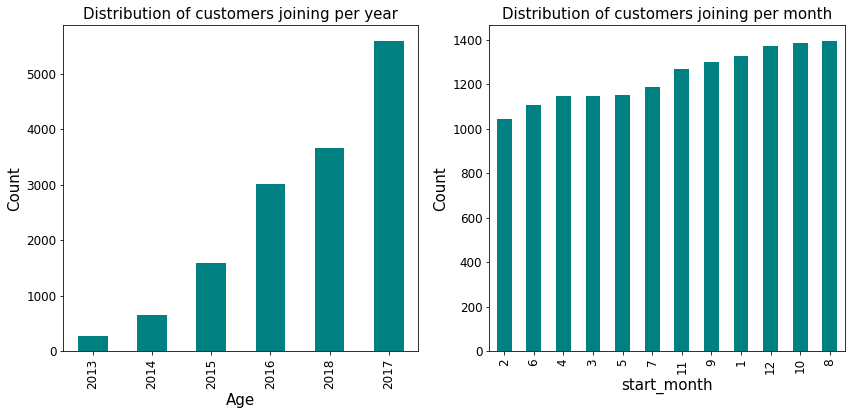

In [19]:
fig, ax = plt.subplots(figsize=(14, 6), nrows=1, ncols=2)

# plot a start_year distribution
plt.sca(ax[0])
profile['start_year'].value_counts().sort_values(ascending=True).plot.bar(figsize=(14,6),fontsize=12,color='teal');
plt.xlabel('Age', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Distribution of customers joining per year', fontsize=15)

# plot a member_month distribution
plt.sca(ax[1])
profile['start_month'].value_counts().sort_values(ascending=True).plot.bar(figsize=(14,6),fontsize=12,color='teal');
plt.xlabel('start_month',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Distribution of customers joining per month',fontsize=15);

In [20]:
# Create gender_by_year_df dataframe to be used to create visualization
gender_by_year_df = pd.DataFrame(profile.groupby(['start_year'])['gender'].value_counts())
gender_by_year_df.rename(columns = {'gender': 'gender_count'}, inplace=True)
gender_by_year_df.reset_index(inplace=True)
gender_by_year_df

,start_year,gender,gender_count
0,2013,1,197
1,2013,0,77
2,2014,1,520
3,2014,0,142
4,2015,1,905
5,2015,0,692
6,2016,0,1541
7,2016,1,1483
8,2017,1,3067
9,2017,0,2532


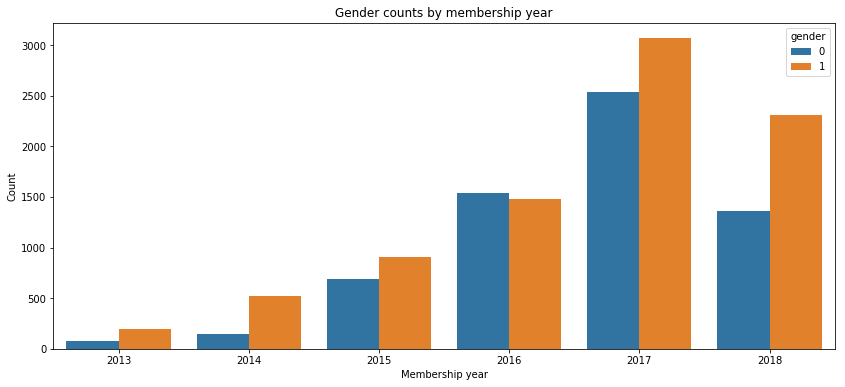

In [21]:
#Plot gender counts per membership year
fig, ax = plt.subplots(figsize=(14, 6),nrows=1, ncols=1)
sns.barplot(x='start_year', y='gender_count', hue='gender', data=gender_by_year_df)
plt.xlabel('Membership year')
plt.ylabel('Count')
plt.title('Gender counts by membership year')
plt.show()

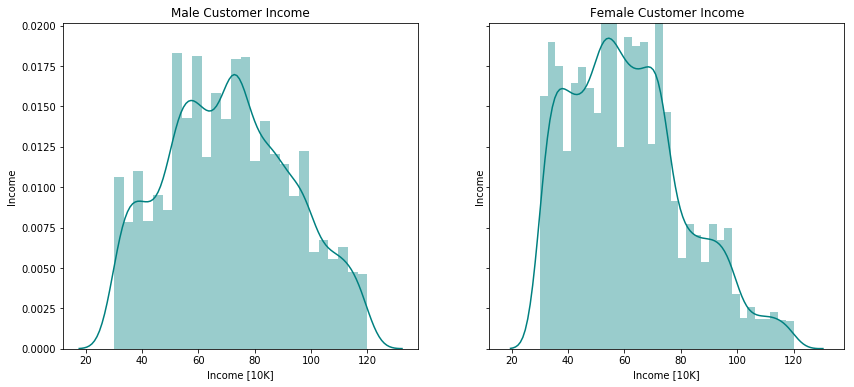

In [22]:
fig, ax = plt.subplots(figsize=(14, 6), nrows=1, ncols=2, sharex=True, sharey=True)

# plot a male customers income distribution
plt.sca(ax[0])
sns.distplot(profile[profile['gender'] == 0]['income'] * 1E-3, color='teal')
plt.xlabel('Income [10K]')
plt.ylabel('Income')
plt.title('Male Customer Income')

# plot a female customers income distribution
plt.sca(ax[1])
sns.distplot(profile[profile['gender'] == 1]['income'] * 1E-3,color='teal')
plt.xlabel('Income [10K]')
plt.ylabel('Income')
plt.title('Female Customer Income');

In [23]:
profile.head()

,age,became_member_on,gender,customer_id,income,start_year,start_month
1,55.0,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7
3,75.0,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5
5,68.0,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,4
8,65.0,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2
12,58.0,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11


## Transaction description

In [24]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [25]:
transcript.shape

(306534, 4)

In [26]:
# Calculate null values in transcript dataframe
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [27]:
# explore transcript
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [28]:
# Calculate the percentage of unique values in event feature
round((transcript['event'].value_counts()/transcript['event'].value_counts().sum())*100,2)

transaction        45.33
offer received     24.88
offer viewed       18.83
offer completed    10.95
Name: event, dtype: float64

In [29]:

#Change name of feature person to customer_id in transcript dataframe
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [54]:
def cleaning_transcript(transcript):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    transcript - the cleaned offer dataframe
    
    '''
    transcript['offer_id'] = ''
    transcript['amount'] = 0
    transcript['reward'] = 0
    #Iterate over value column, check it and update offer_id, amount, reward columns
    for index, row in transcript.iterrows():
        for i in row['value']:
            if i == 'offer_id' or i == 'offer id':
                transcript.at[index, 'offer_id']= row['value'][i]
            if i == 'amount':
                transcript.at[index, 'amount']= row['value'][i]
            if i == 'reward':
                transcript.at[index, 'reward']= row['value'][i]
                
    # map offer type to offer id           
    offers_map = {
        'fafdcd668e3743c1bb461111dcafc2a4' : 'discount',
        '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount',
        '2298d6c36e964ae4a3e7e9706d1fb8c2':'discount',
        '2906b810c7d4411798c6938adc9daaa5':'discount',
        'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo',
        '4d5c57ea9a6940dd891ad53e9dbe8da0':'bogo',
        '9b98b8c7a33c4b65b9aebfe6a799e6d9':'bogo',
        'f19421c1d4aa40978ebb69ca19b0e20d':'bogo',
        '3f207df678b143eea3cee63160fa8bed':'informational',
        '5a8bc65990b245e5a138643cd4eb9837':'informational',
        
    }
    
    #create offer_type column 
    transcript['offer_type'] = transcript['offer_id'].map(offers_map)
    
    # OneHotEncoding feature 'offer type'
    transcript = pd.get_dummies(transcript, columns=['offer_type'], prefix='', prefix_sep='')

    # OneHotEncoding feature 'income_by_range'
    transcript = pd.get_dummies(transcript, columns=['event'])
    
    # Change column names
    transcript.rename(columns = {'event_offer received': 'offer_received',
                            'event_offer viewed': 'offer_viewed',
                            'event_offer completed': 'offer_completed'}, inplace=True)
    
    # Drop value column
    transcript.drop(columns=['value','offer_id','event_transaction'], axis = 1, inplace = True)

    return transcript

In [55]:
cleaning_transcript(transcript).head()

,customer_id,time,amount,reward,bogo,discount,informational,offer_completed,offer_received,offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,1,0,0,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,0,0,0,1,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,0,0,0,1,0,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,0,0,1,0,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,0,0,1,0,0,0,1,0
